# Analysis of conversations in the Reddit "chairs" community for keyword "ergonomic".
Submitted by : Uday Lal Shaw<br>
Student Id: 10002226

In [1]:
import praw
from praw.models import MoreComments
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from igraph import Graph, plot
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

reddit = praw.Reddit(
    client_id='ZMnTqKHi2LJ3JSH3gRaq7Q',
    client_secret='8GWG5Fc8vwkCy8RdzSk-OPmmZbf3CQ',
    user_agent='YOUR_USER_AGENT',
)

#### Function to get all the posts, comments and replies from the reddit community

In [2]:
def get_submission(hot_submissions):
    submission_list=[]
    submission_no=1
    for submission in hot_submissions:
        submission_attrs={}
        submission_attrs["s_no"]=submission_no
        submission_attrs["s_id"]=submission.id
        submission_attrs["s_title"]=submission.title
        submission_attrs["s_author"]=submission.author
        submission_attrs["s_score"]=submission.score
        submission_attrs["s_url"]=submission.url
        
        comment_list=[]
        submission.comments.replace_more(limit=None)
        #top_level_comment_no=1
        for top_level_comment in submission.comments.list():
            comment_attr={}
            #comment_attr["c_no"]=str(submission_no)+"_"+str(top_level_comment_no)
            comment_attr["c_id"]=top_level_comment.id
            comment_attr["c_author"]=top_level_comment.author
            comment_attr["c_body"]=top_level_comment.body
            
            reply_list=[]
            #reply_no=1
            for reply in top_level_comment.replies:
                reply_attr={}
                #reply_attr["r_no"]=str(submission_no)+"_"+str(top_level_comment_no)+"_"+str(reply_no)
                reply_attr["r_id"]=reply.id
                reply_attr["r_author"]=reply.author
                reply_attr["r_body"]=reply.body
                reply_list.append(reply_attr)
                #reply_no=reply_no+1
                
            comment_attr["replies"]=reply_list
            comment_list.append(comment_attr)
            #top_level_comment_no=top_level_comment_no+1
            
        submission_attrs["comments"]=comment_list
        submission_list.append(submission_attrs)
        print("processed submission:",submission_no)
        submission_no=submission_no+1
        
    return submission_list

#### Reading from Reddit

In [3]:
# Specify the subreddit and topic you are interested in
subreddit_name = 'OfficeChairs'
topic_keyword='ergonomic'
# Get the subreddit instance
subreddit = reddit.subreddit(subreddit_name)

# Search for the top 10 hot submissions containing the specified keyword
hot_submissions = subreddit.search(topic_keyword, sort='hot', limit=100)

submission_list=get_submission(hot_submissions=hot_submissions)

processed submission: 1
processed submission: 2
processed submission: 3
processed submission: 4
processed submission: 5
processed submission: 6
processed submission: 7
processed submission: 8
processed submission: 9
processed submission: 10
processed submission: 11
processed submission: 12
processed submission: 13
processed submission: 14
processed submission: 15
processed submission: 16
processed submission: 17
processed submission: 18
processed submission: 19
processed submission: 20
processed submission: 21
processed submission: 22
processed submission: 23
processed submission: 24
processed submission: 25
processed submission: 26
processed submission: 27
processed submission: 28
processed submission: 29
processed submission: 30
processed submission: 31
processed submission: 32
processed submission: 33
processed submission: 34
processed submission: 35
processed submission: 36
processed submission: 37
processed submission: 38
processed submission: 39
processed submission: 40
processed

#### process data to get all the fields in seperate column from the json created after reading from Reddit

In [4]:
df=pd.DataFrame(submission_list)
df_1=df.explode('comments').reset_index(drop=True)
df_2 = pd.concat([df_1, df_1['comments'].apply(lambda x: pd.Series(x))], axis=1).drop([0], axis=1)
df_3=df_2.explode('replies').reset_index(drop=True)
df_4 = pd.concat([df_3, df_3['replies'].apply(lambda x: pd.Series(x))], axis=1).drop([0], axis=1)


In [5]:
df_4[['s_no','s_id','s_author','c_id','c_author','r_id','r_author','c_body','r_body']]

s_no     s_id              s_author     c_id             c_author  \
0       1  19c0ogu            Ejziponken      NaN                  NaN   
1       2  19abm6a             happisces  kik2ei9       LovePeaceTruth   
2       2  19abm6a             happisces  kik2ei9       LovePeaceTruth   
3       2  19abm6a             happisces  kiv5x2n           ergothrone   
4       2  19abm6a             happisces  kiv5p7d           ergothrone   
..    ...      ...                   ...      ...                  ...   
792    99  17o7inu  Outrageous_Till_3288  k7y441w  Equivalent_Box_9839   
793   100  17p30c8           NarutoNamii  k82llv0   No-Consequence1726   
794   100  17p30c8           NarutoNamii  k82lmjk   No-Consequence1726   
795   100  17p30c8           NarutoNamii  k99o5yj   Consistent_Win6294   
796   100  17p30c8           NarutoNamii  k9j42zq      PromotionNo7568   

        r_id         r_author  \
0        NaN              NaN   
1    kiv5p7d       ergothrone   
2    kik2ijj        happisces   
3        NaN              NaN   
4        NaN              NaN   
..       ...              ...   
792      NaN              NaN   
793      NaN              NaN   
794      NaN              NaN   
795  k9j42zq  PromotionNo7568   
796      NaN              NaN   

                                                c_body  \
0                                                  NaN   
1    According to this article, those chairs are al...   
2    According to this article, those chairs are al...   
3    The Duo-EX and TP9000 seats are almost certain...   
4    Careful! A 5'2" computer user should keep thei...   
..                                                 ...   
792                                  Its not ergonomic   
793  its just a generic piece of crap.  \n\n\nMaybe...   
794  its just a generic piece of crap.  \n\n\nMaybe...   
795  I'd recommend the Primal UnChair! It's a handm...   
796  how big is this chair? I can't figure out if i...   

                                                r_body  
0                                                  NaN  
1    Careful! A 5'2" computer user should keep thei...  
2    ok cool i’ll definitely factor that into my se...  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
792                                                NaN  
793                                                NaN  
794                                                NaN  
795  how big is this chair? I can't figure out if i...  
796                                                NaN  

[797 rows x 9 columns]

In [22]:
df_4.to_csv("extracted_reddit_data.csv", header=True,index=False)

#### Identifing node and edges from the data to build graph.
All authors are considered node, and whenever a author has commented or replied to another author than a edge is identified

In [6]:
df_sub_com=df_4[['s_author','c_author']].rename(columns={"s_author":"source","c_author":"target"}).drop_duplicates()
df_com_rep=df_4[['c_author','r_author']].rename(columns={"c_author":"source","r_author":"target"}).drop_duplicates()
df_edges=pd.concat([df_sub_com,df_com_rep]).drop_duplicates()
df_edges=df_edges.dropna().reset_index(drop=True)
df_edges

source            target
0             happisces    LovePeaceTruth
1             happisces        ergothrone
2             happisces         happisces
3       anxiety_fitness        DnBenjamin
4       anxiety_fitness   Advanced_Ad7292
..                  ...               ...
668       exdigguser147  lusco-fusco-wdyd
669    lusco-fusco-wdyd     exdigguser147
670         TheEmfinger           ha11ion
671    ClassroomDecorum           ha11ion
672  Consistent_Win6294   PromotionNo7568

[673 rows x 2 columns]

In [7]:
authors=list(set(list(df_edges['source'].apply(lambda x: x.name)) +list(df_edges['target'].apply(lambda x: x.name))))
print("Total authors identified:",len(authors))

Total authors identified: 348


In [8]:
df_graph=pd.DataFrame()
df_graph['source']=df_edges['source'].apply(lambda x: authors.index(x))
df_graph['target']=df_edges['target'].apply(lambda x: authors.index(x))

#### Building the graph

In [9]:
from igraph import Graph
# Create an igraph graph from the pandas DataFrame
graph = Graph.TupleList(df_graph.itertuples(index=False), directed=True)
graph.vs['label']=authors
vertex_colors = ['red', 'green', 'blue', 'yellow']
# Print the graph summary
print(graph.summary())


IGRAPH DN-- 348 673 -- 
+ attr: label (v), name (v)


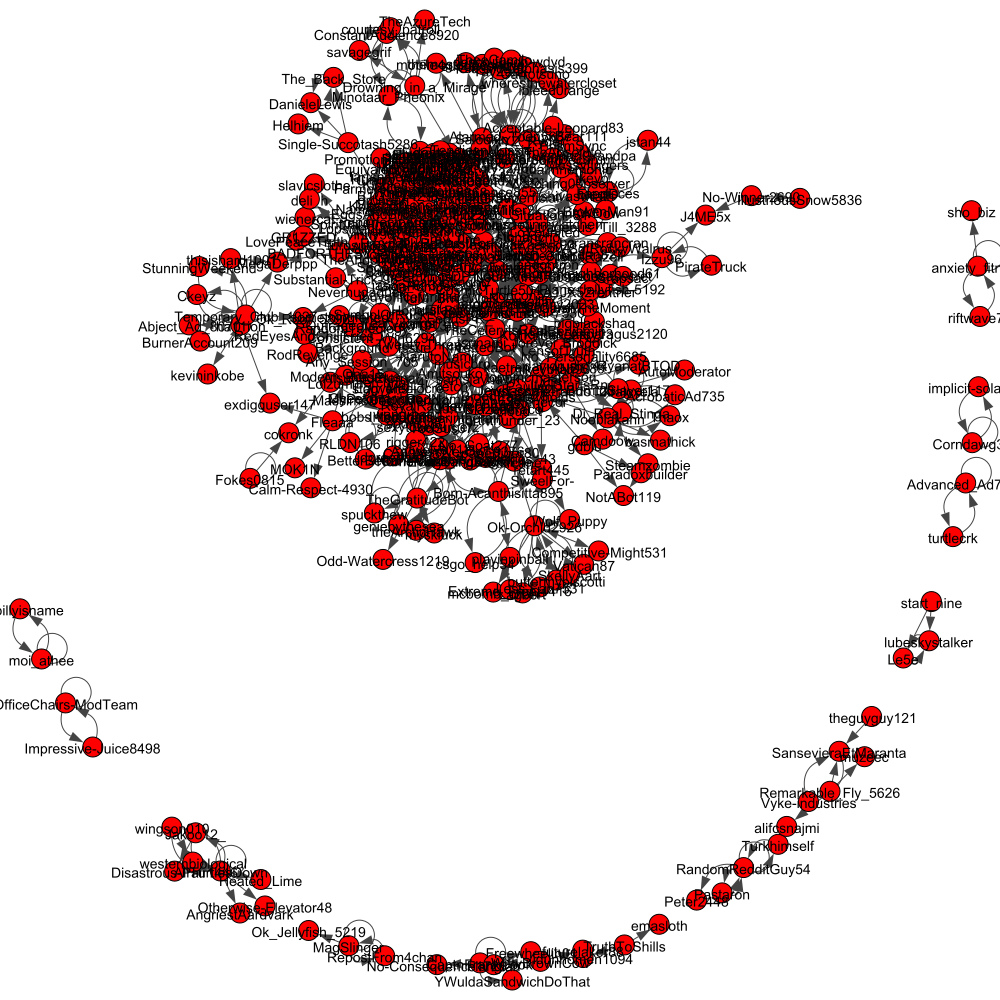

In [10]:
# Specify the layout (e.g., the Kamada-Kawai layout)
layout = graph.layout_kamada_kawai()

# Plot the graph
plot(graph, layout=layout, bbox=(1000, 1000), margin=20)


#### Calculating degree centrality and other parameters to identify influencers in the graph

In [11]:
df_node=pd.DataFrame()
df_node["name"]=graph.vs["label"]
df_node["Degree centrality"]=graph.degree()  ##getting the degree of each node
df_node["eigenvector_centrality"]=graph.eigenvector_centrality() ## gettting eigenvector_centrality for each node
df_node["Closeness centrality"]=graph.closeness()
df_node["Betweenness centrality"]=graph.betweenness()
df_node["Page Rank"]=graph.pagerank()

df_node.sort_values(["Page Rank"], ascending=False)

name  Degree centrality  eigenvector_centrality  \
2            omeggga                 44            1.000000e+00   
162          RLDN106                  5            2.131965e-02   
241        Geekberry                 21            4.484168e-01   
15      Egg_Mediocre                 12            8.247258e-02   
18    Sparklebright7                 14            2.229501e-01   
..               ...                ...                     ...   
98      davidrush144                  1            8.279219e-18   
79   Virtual-Ad-8504                  2            8.279219e-18   
95        start_nine                  2            8.279219e-18   
49            Fleaaa                  5            8.279219e-18   
299   TendiesnMussie                  2            8.279219e-18   

     Closeness centrality  Betweenness centrality  Page Rank  
2                0.377972            12055.264194   0.022815  
162              0.206991              129.000000   0.022617  
241              0.311662             5341.714991   0.022133  
15               0.260569              257.000000   0.018028  
18               0.317227             1851.301263   0.015707  
..                    ...                     ...        ...  
98               0.233025                0.000000   0.000885  
79               0.275296                0.000000   0.000885  
95               1.000000                0.000000   0.000885  
49               0.210747                0.000000   0.000885  
299              0.241407                0.000000   0.000885  

[348 rows x 6 columns]

#### Community identification using leading eigenvector algorithm

In [12]:
communities=graph.community_leading_eigenvector()
# Get the number of communities detected
num_communities = len(communities)

print("Number of Communities detected:", num_communities)

Number of Communities detected: 31


C:\Users\UDAY\AppData\Local\Programs\Python\Python39\lib\site-packages\igraph\community.py:98: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:393
  membership, _, q = GraphBase.community_leading_eigenvector(graph, clusters, **kwds)


#### Identifing community no. for each author as well as assiging a color to the community

In [13]:
label_com={}
com_no={}
vertex_colors=[
    '#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a',
    '#b15928', '#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f',
    '#cab2d6', '#ffff99', '#cccccc', '#8dd3c7', '#bebada',
    '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5',
    '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f', '#1b9e77',
    '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
    '#a6761d', '#666666', '#a6611a', '#018571', '#018571' 
]
for i in range(num_communities):
    for j in communities.subgraph(i).vs['label']:
        label_com[j]=vertex_colors[i]
        com_no[j]=i
        #if j in com_no:
        #    com_no[j].append(i)
        #else:
        #    com_no[j]=[i]

vc=[]
vs_com=[]
for i in authors:
    vc.append(label_com[i])
    vs_com.append(com_no[i])

For further analysis we will consider communities that have more than or equal to 5 members

In [14]:
df_node["community"]=df_node["name"].apply(lambda x: com_no[x])
community_group=df_node.groupby("community").agg(node_count=("name","count")).sort_values(["node_count"], ascending=False)
communities=community_group[community_group["node_count"]>=5]
communities

node_count
community            
14                 91
0                  29
15                 29
22                 28
23                 20
21                 19
17                 18
19                 16
28                 12
18                 10
10                  8
20                  7
16                  7
12                  6
29                  5
25                  5

#### Plotting the entire graph, that shows all different communities interacting with each other

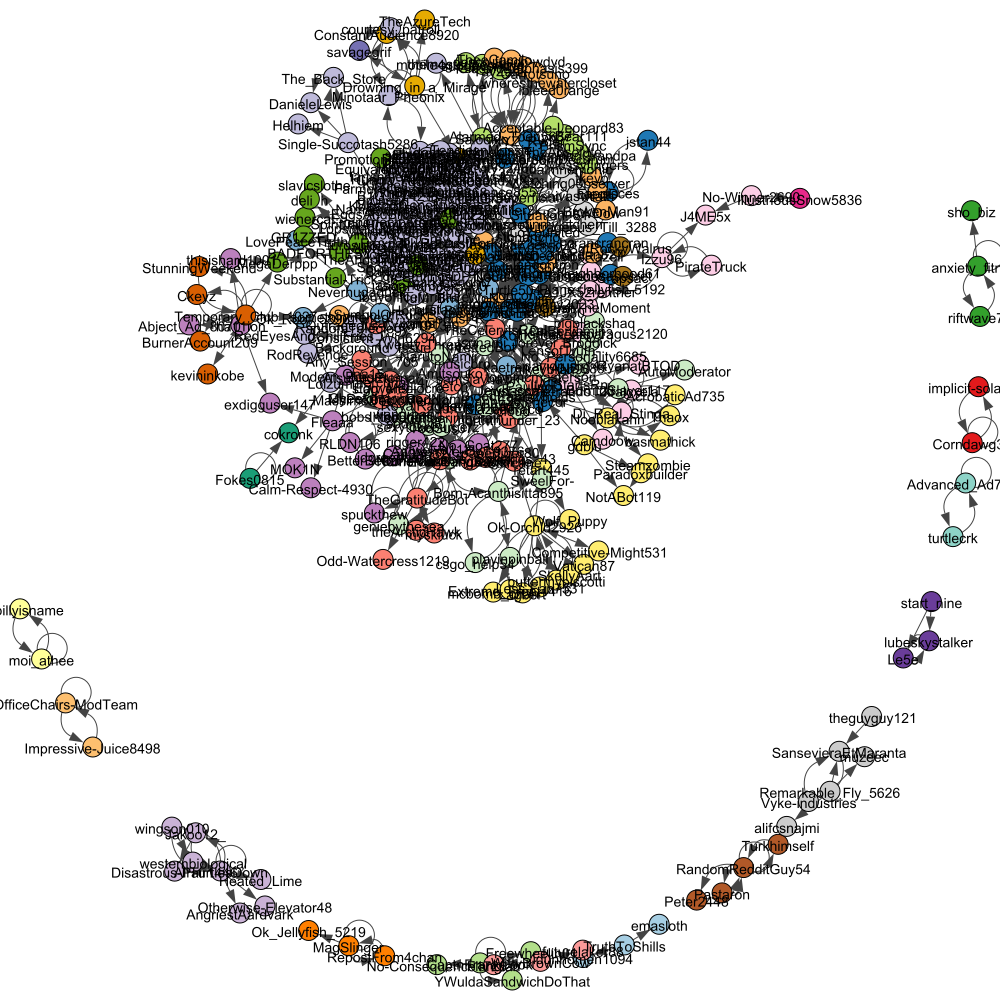

In [15]:
layout = graph.layout_kamada_kawai()
graph.vs['community_no']=vs_com
graph.vs['color']=vc
# Plot the graph with colored nodes
plot(graph, layout=layout, bbox=(1000, 1000), margin=20, vertex_label=graph.vs['label'], vertex_color=graph.vs['color'])

#### Plotting one of the sub-communities that we identified

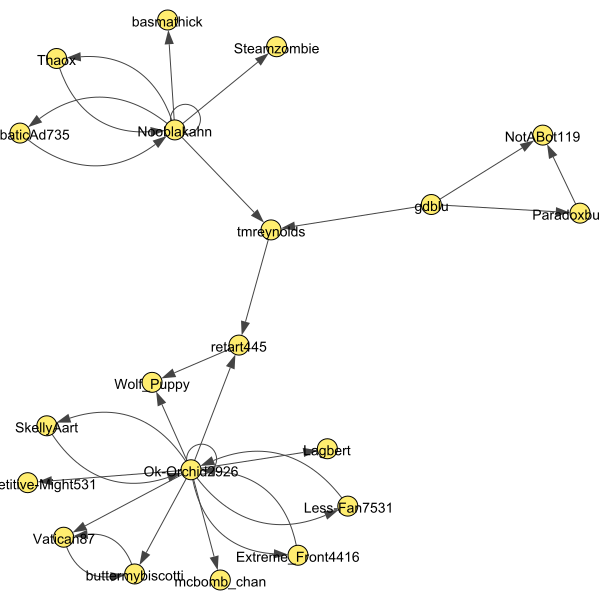

In [16]:
target_community=23
selected_nodes = [v.index for v in graph.vs if v['community_no'] == target_community]
subgraph = graph.subgraph(selected_nodes)
layout = subgraph.layout_kamada_kawai()
plot(subgraph, layout=layout, bbox=(600, 600), margin=20, vertex_label=subgraph.vs['label'], vertex_color=subgraph.vs['color'])

#### identifying influencers for each sub-community

In [17]:
for target_community in communities.index:
    print("\n\nCommunity no.:", target_community, "\ncommunity member count:", communities.loc[target_community,"node_count"])
    print(df_node[df_node["community"]==target_community].sort_values(["Degree centrality"],ascending=False).head(2)[["name","Degree centrality"]])



Community no.: 14 
community member count: 91
            name  Degree centrality
195  thisisfiner                 84
241    Geekberry                 21


Community no.: 0 
community member count: 29
              name  Degree centrality
2          omeggga                 44
4  tsunami_forever                 14


Community no.: 15 
community member count: 29
                name  Degree centrality
155   Twenty-Three23                 22
85   TheCeleryIsReal                 13


Community no.: 22 
community member count: 28
           name  Degree centrality
25    VettedBot                 24
62  NarutoNamii                 16


Community no.: 23 
community member count: 20
              name  Degree centrality
144  Ok-Orchid2926                 16
328     Nooblakahn                  9


Community no.: 21 
community member count: 19
             name  Degree centrality
15   Egg_Mediocre                 12
121     Amitsouko                 11


Community no.: 17 
community member cou

#### Keyword analysis for the entire community

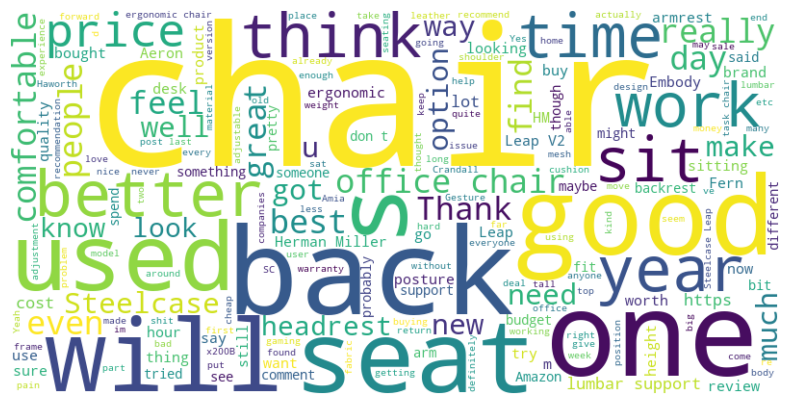

In [18]:
conversations=pd.concat([df_4['s_title'],df_4['c_body'],df_4['r_body']]).dropna().drop_duplicates()
# Concatenate all text into a single string
text = ' '.join(conversations)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using seaborn
plt.figure(figsize=(10, 5))
sns.set(rc={'axes.facecolor': 'white', 'figure.facecolor': 'white'})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### keyword analysis for each sub-community



Community no.: 14 
community member count: 91


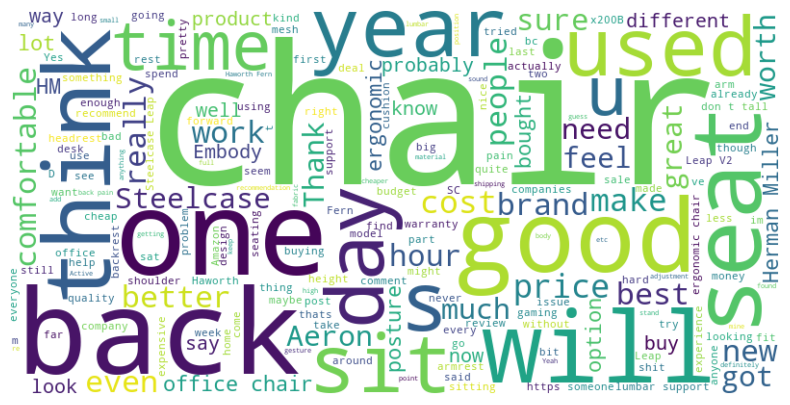



Community no.: 0 
community member count: 29


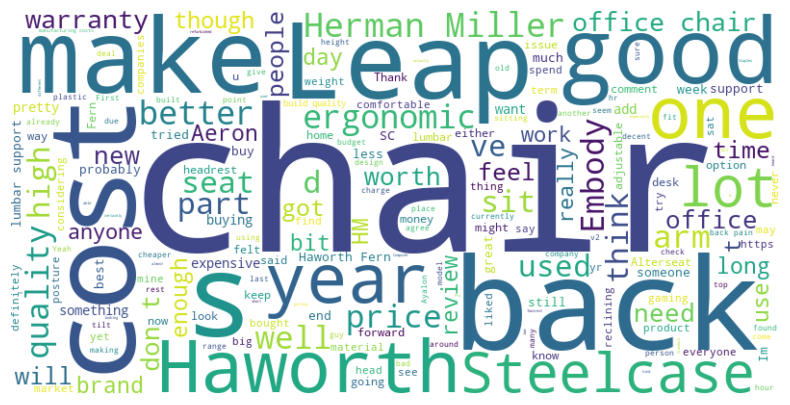



Community no.: 15 
community member count: 29


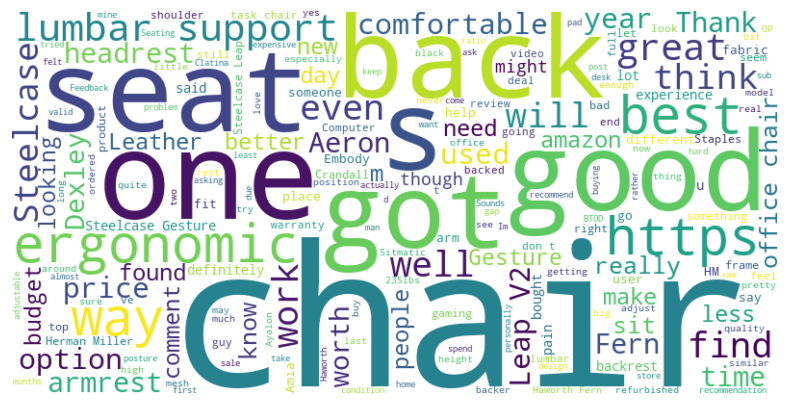



Community no.: 22 
community member count: 28


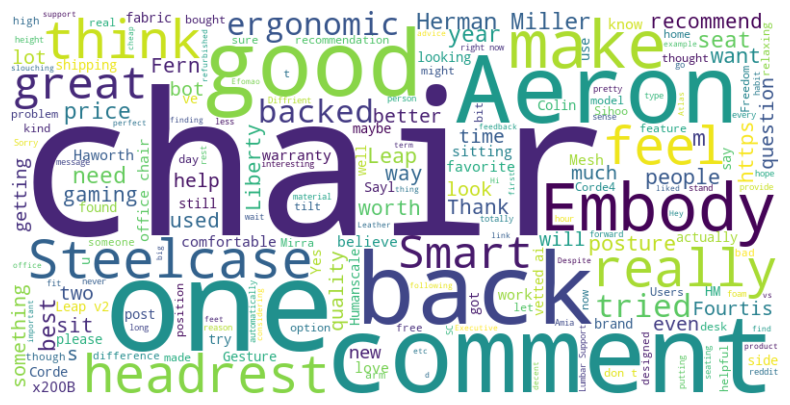



Community no.: 23 
community member count: 20


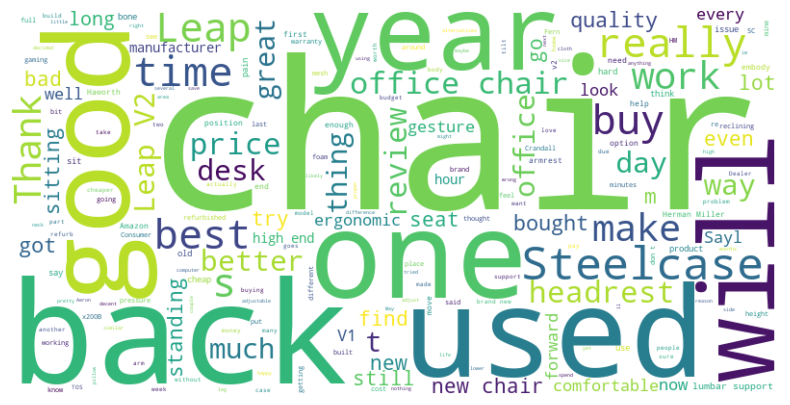



Community no.: 21 
community member count: 19


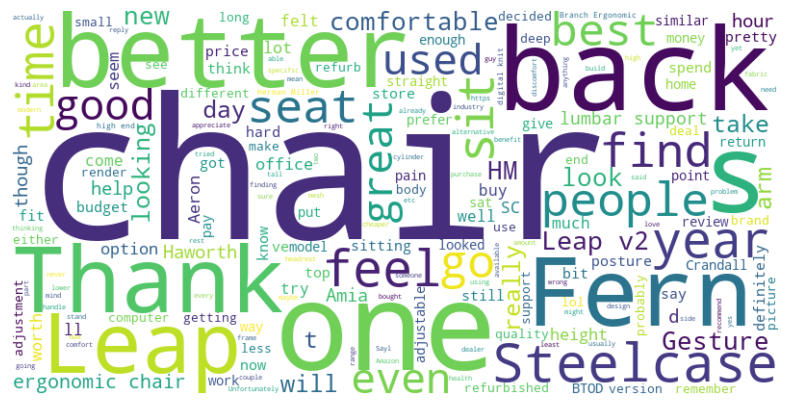



Community no.: 17 
community member count: 18


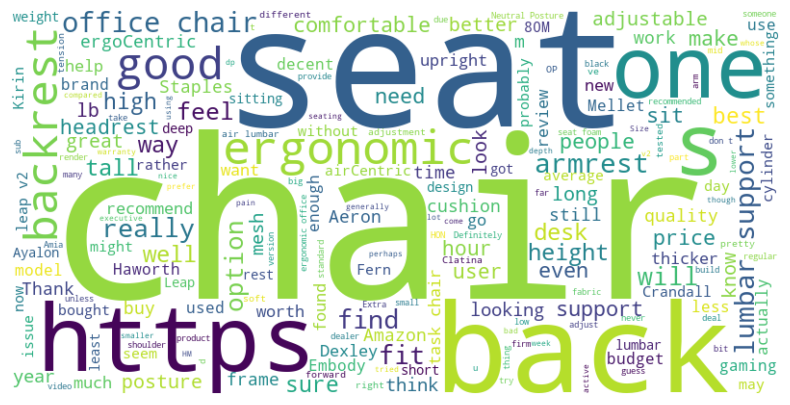



Community no.: 19 
community member count: 16


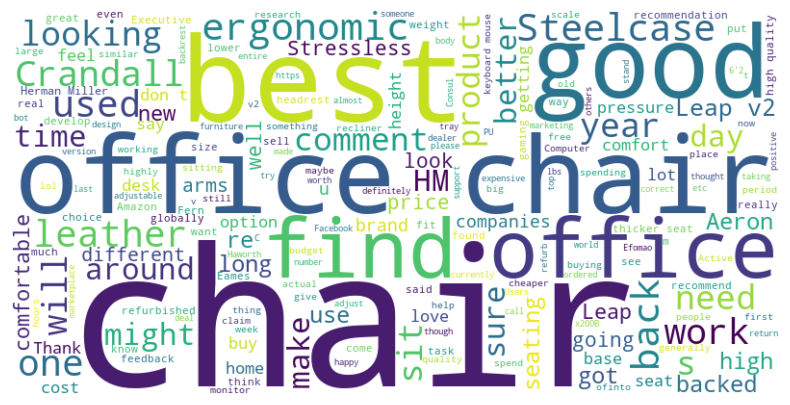



Community no.: 28 
community member count: 12


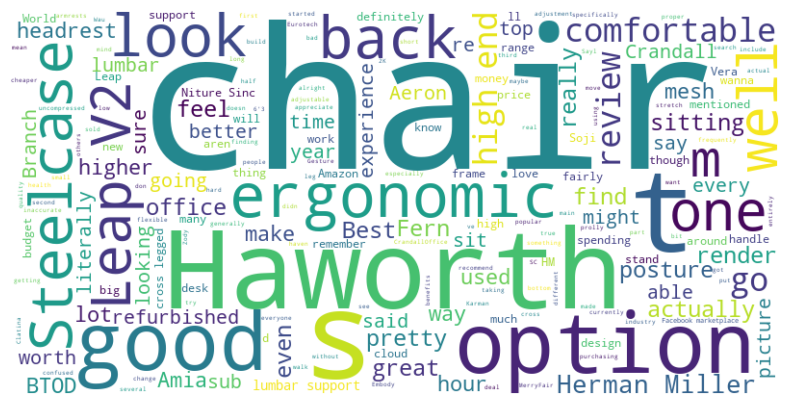



Community no.: 18 
community member count: 10


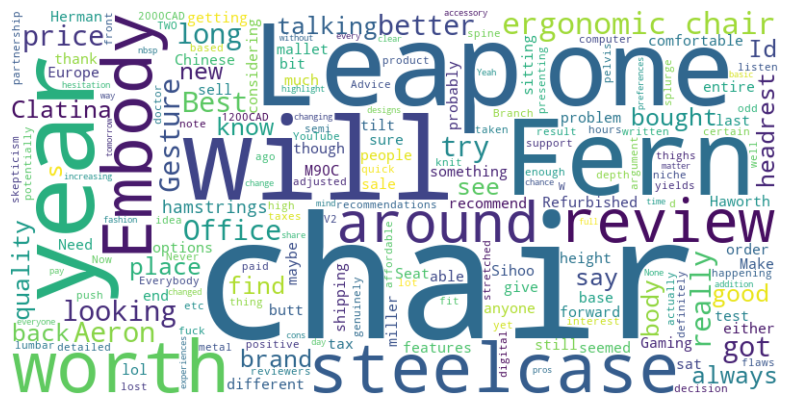



Community no.: 10 
community member count: 8


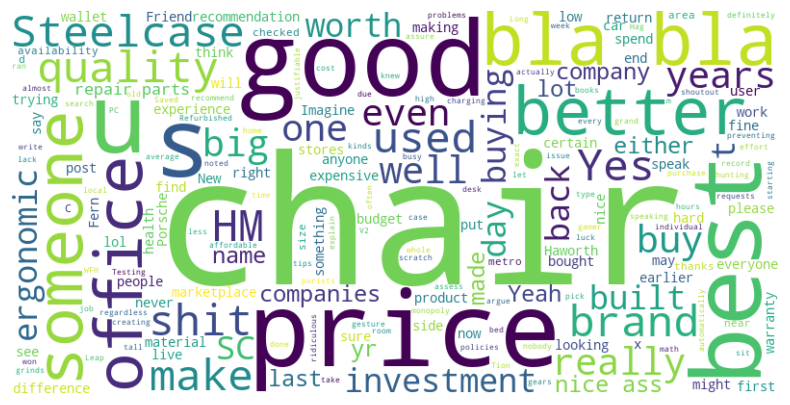



Community no.: 20 
community member count: 7


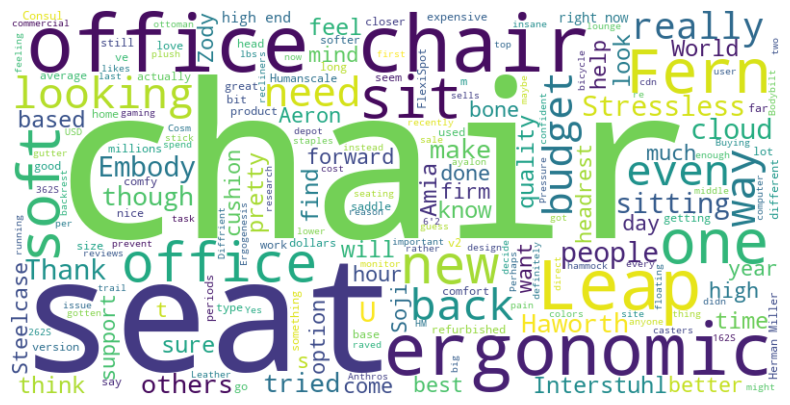



Community no.: 16 
community member count: 7


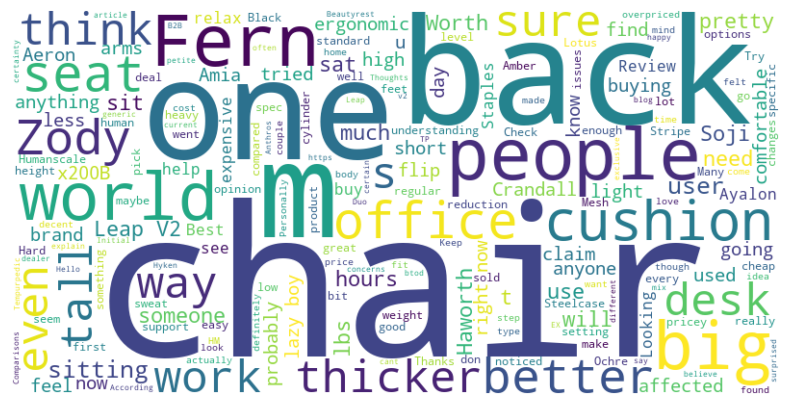



Community no.: 12 
community member count: 6


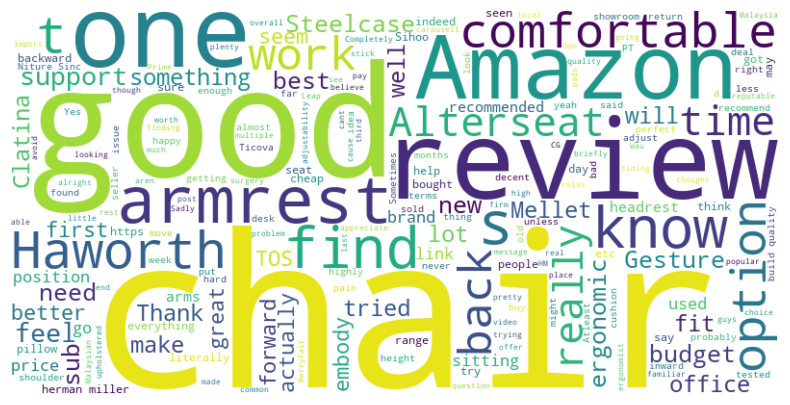



Community no.: 29 
community member count: 5


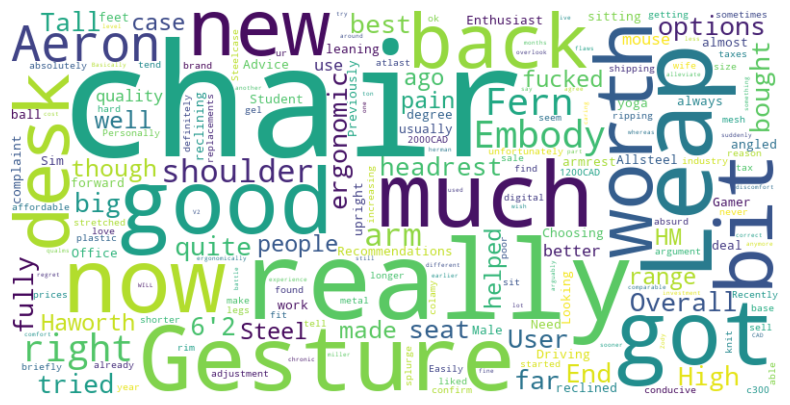



Community no.: 25 
community member count: 5


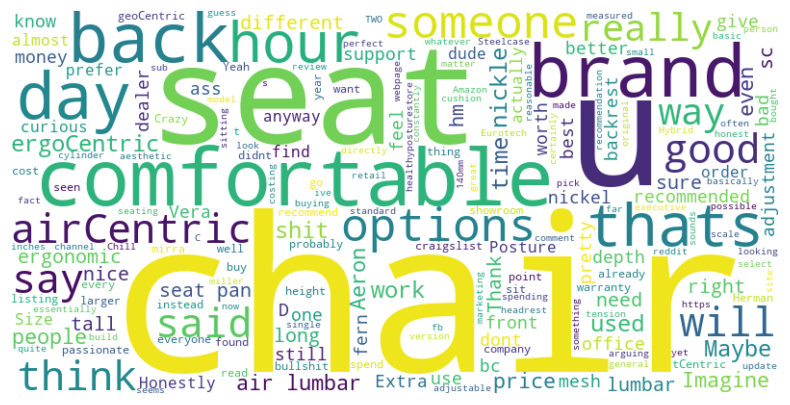

In [19]:
for target_community in communities.index:
    print("\n\nCommunity no.:", target_community, "\ncommunity member count:", communities.loc[target_community,"node_count"])
    namelist=set(df_node[df_node["community"]==target_community]['name'])
    #print(namelist)
    df_community=df_4[(df_4['s_author'].apply(lambda x: str(x)).isin(namelist)) |
    (df_4['c_author'].apply(lambda x: str(x)).isin(namelist)) |
    (df_4['r_author'].apply(lambda x: str(x)).isin(namelist))]
    
    conversations_in_community=pd.concat([df_community['s_title'],df_community['c_body'],df_community['r_body']]).dropna().drop_duplicates()
    #conversations_in_community
    
    # Concatenate all text into a single string
    text = ' '.join(conversations_in_community)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the word cloud using seaborn
    plt.figure(figsize=(10, 5))
    sns.set(rc={'axes.facecolor': 'white', 'figure.facecolor': 'white'})
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


## Topic modelling for sub-communities

In [20]:
# Function to preprocess text data
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english') + list(string.punctuation))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


In [21]:
for target_community in communities.index:
    print("\n\nCommunity no.:", target_community, "\ncommunity member count:", communities.loc[target_community,"node_count"])
    namelist=set(df_node[df_node["community"]==target_community]['name'])
    df_community=df_4[(df_4['s_author'].apply(lambda x: str(x)).isin(namelist)) |
    (df_4['c_author'].apply(lambda x: str(x)).isin(namelist)) |
    (df_4['r_author'].apply(lambda x: str(x)).isin(namelist))]
    conversations_in_community=pd.concat([df_community['s_title'],df_community['c_body'],df_community['r_body']]).dropna().drop_duplicates()
    data = conversations_in_community
    df_lda = pd.DataFrame(data).rename(columns={0:"document"})
    
    # Preprocess the documents in the DataFrame
    df_lda['processed_text'] = df_lda['document'].apply(preprocess_text)
    
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(df_lda['processed_text'])
    
    # Convert the documents to a bag-of-words corpus
    corpus = [dictionary.doc2bow(text) for text in df_lda['processed_text']]
    
    # Apply LDA model
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
    
    # Print the topics
    print("LDA Topics:")
    for topic_id, words in lda_model.print_topics():
        print(f"Topic ID: {topic_id}")
        print(f"Words: {words}\n")
    
    # Assign topics to documents
    #df_lda['lda_topics'] = df_lda['processed_text'].apply(lambda x: lda_model[dictionary.doc2bow(x)])
    
    # Print document topics
    #for index, row in df_lda.iterrows():
    #    print(f"Document {index + 1}: {row['document']}")
    #    print(f"Topics: {row['lda_topics']}\n")




Community no.: 14 
community member count: 91
LDA Topics:
Topic ID: 0
Words: 0.039*"chair" + 0.009*".." + 0.008*"n't" + 0.008*"cost" + 0.007*"office" + 0.007*"like" + 0.007*"would" + 0.006*"one" + 0.005*"’" + 0.005*"good"

Topic ID: 1
Words: 0.035*"chair" + 0.011*"like" + 0.010*"'s" + 0.009*"year" + 0.008*"n't" + 0.007*"leap" + 0.007*"one" + 0.006*"good" + 0.006*"would" + 0.006*"used"

Topic ID: 2
Words: 0.027*"’" + 0.020*"chair" + 0.017*"back" + 0.011*"seat" + 0.010*"'s" + 0.008*"lumbar" + 0.007*"like" + 0.007*"support" + 0.007*"n't" + 0.006*"one"



Community no.: 0 
community member count: 29
LDA Topics:
Topic ID: 0
Words: 0.038*"chair" + 0.025*"’" + 0.010*"back" + 0.008*"quality" + 0.007*"year" + 0.007*"office" + 0.007*"leap" + 0.007*"one" + 0.006*"good" + 0.006*"steelcase"

Topic ID: 1
Words: 0.011*"like" + 0.010*"arm" + 0.009*"chair" + 0.008*"better" + 0.008*"leap" + 0.007*"seat" + 0.007*"embody" + 0.007*"'s" + 0.007*"back" + 0.007*"would"

Topic ID: 2
Words: 0.032*"chair" + 0.